# Data Analysis Phase
In this notebook I'm running the data analysis phase on the **Uber Fare Prices Dataset**. This dataset is available on a <a href="https://www.kaggle.com/datasets/yasserh/uber-fares-dataset" target="blank">Kaggle</a>. In this dataset, there are more than 200K observations with a total of 9 columns.

<img src="https://i.ibb.co/X7M4SK5/Screenshot-from-2022-07-01-10-12-49.png" width=900 />

The columns on the dataset are:
+ **key**                 -> an unique identifier for each trip (useless for modeling)
+ **fare_amout**          -> the cost of each trip in USD (target variable)
+ **pickup_datetime**     -> the precime datetime when the passenger was picked up
+ **passenger_count**     -> the quantity of passengers
+ **pickup_longitude**    -> the longitude where the trip began
+ **pickup_latitude**     -> the latitude where the trip began
+ **dropoff_longitude**   -> the longitude where the trip ended
+ **dropoff_latitude**    -> the latitude where the trip ended

***
This project is meant to be part of my personal portfolio.

**Author**: Arthur G.

## Importing Dependencies
Here I'm importing all the dependencies for this notebook.

In [1]:
# libs
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson, boxcox
from src.visualization.visualize import calc_feature_importance

# settings
seed = np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Loading Data
Now I'll load the processed dataset.

In [2]:
df = pd.read_csv(os.path.join('..', 'data', 'processed', 'processed_uber_trip_tax_data.csv'))
df.head()

,pickup_year,pickup_month,pickup_dayofyear,pickup_dayofweek,pickup_hour,is_holiday,passenger_count,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_km,fare_amount
0,2015,5,127,3,19,0,1,40.738,-74.000,40.723,-74.000,1.683,7.5
1,2009,7,198,4,20,0,1,40.728,-73.994,40.750,-73.995,2.458,7.7
2,2009,8,236,0,21,0,1,40.741,-74.005,40.773,-73.963,5.036,12.9
3,2009,6,177,4,8,0,3,40.791,-73.976,40.803,-73.965,1.662,5.3
4,2014,8,240,3,17,0,5,40.744,-73.925,40.761,-73.973,4.475,16.0


## Data Analysis
Now it's time to start our (mostly) visual analysis. Let's start off by the target variable, analyzing it's distribution and checking if we can benefit our future model with any data transformation.

### Target Distribution Analysis
Let's see if we have a gaussian-like distribution in our target column.

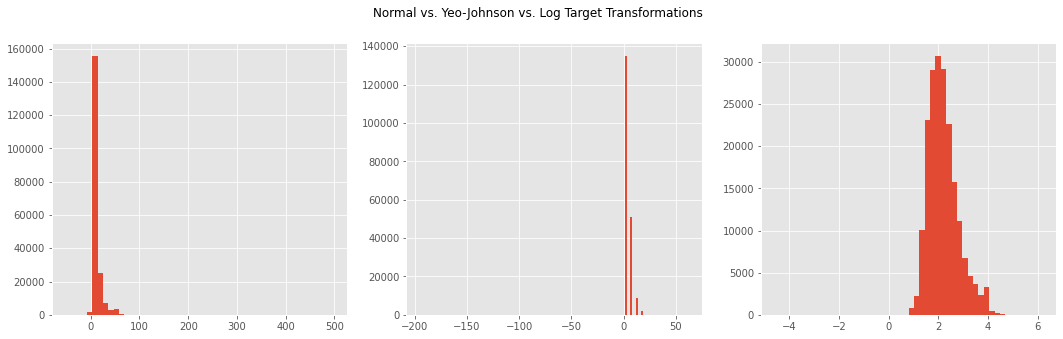

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
axs[0].hist(df.fare_amount.values, bins=50,)
axs[1].hist(yeojohnson(df.fare_amount.values), bins=50)
axs[2].hist(np.log(df.fare_amount.values), bins=50)
fig.suptitle('Normal vs. Yeo-Johnson vs. Log Target Transformations')
plt.show()

We can see that log transforming the target column better expose some predictive pattern to our future regressor, once we have something more of a Gaussian-like distribution.

And about the latitude and longitude columns, thats make no sense to analyze their distribution once they represent a physical location around the world and the difference between each pair of coordinates is a measurement in Km, which highly impacts our target variable. Moreover, both log or yeo-johnson transformations had no effect on their distribution (I've tried previously).

### Mean Fare Analysis
Now I'll be analyzing the mean fare price under different conditions, such as for different days of the week as well as in different hours of the day.

#### Mean Fare Price Per Day of Week
Let's start by analyzing the mean fare price per day of week.

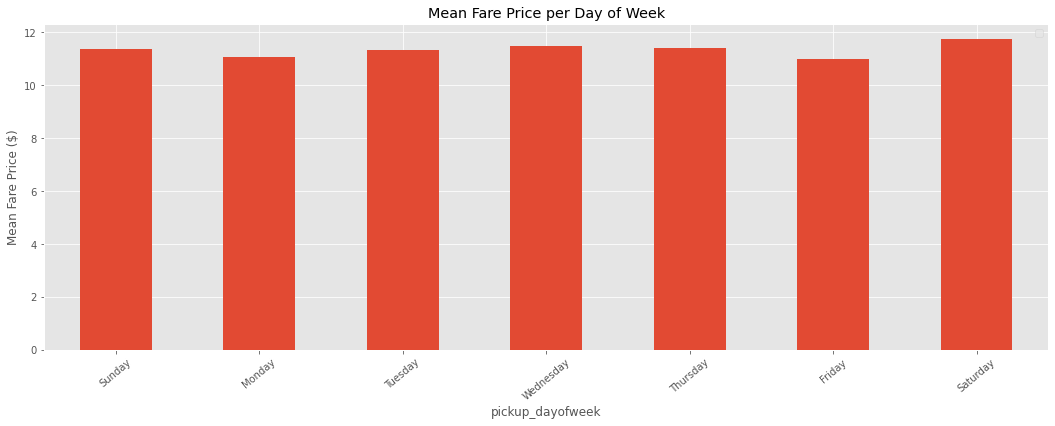

In [4]:
week_days_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

_ = df[['pickup_dayofweek', 'fare_amount']].groupby(['pickup_dayofweek']).mean().plot.bar(figsize=(18, 6))
plt.title('Mean Fare Price per Day of Week')
plt.xticks(range(7), week_days_labels, rotation=40)
plt.legend([])
plt.ylabel('Mean Fare Price ($)')
plt.show()

We can see that usually in saturdays, the fare price tends to increase.

#### Mean Fare Price Per Hour of The Day
Let's see the behavior of fare prices in different hours of the day.

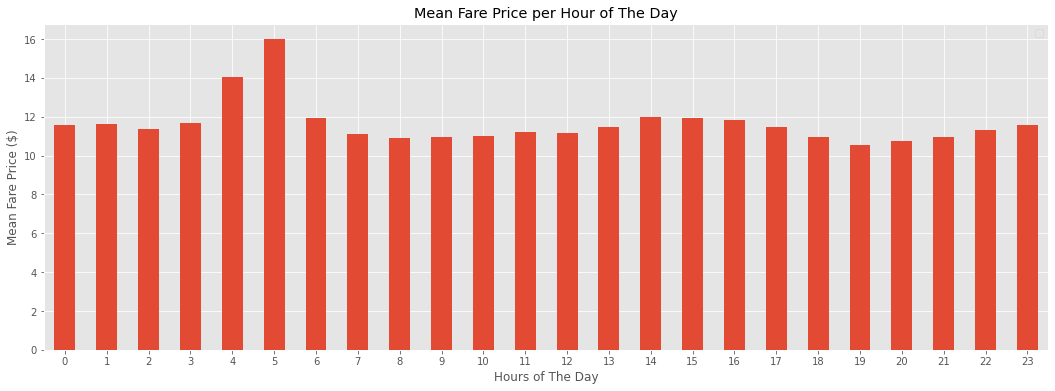

In [5]:
_ = df[['pickup_hour', 'fare_amount']].groupby(['pickup_hour']).mean().plot.bar(figsize=(18, 6))
plt.title('Mean Fare Price per Hour of The Day')
plt.legend([])
plt.xlabel('Hours of The Day')
plt.ylabel('Mean Fare Price ($)')
plt.xticks(rotation=0)
plt.show()

It seems that around 5PM the fare prices got increased. It happens probabliy because this is when people are going back to home after their work journeys.

#### Effect of Holiday in Mean Fare Price
Let's investigate if holidays play an important role on the mean fare price.

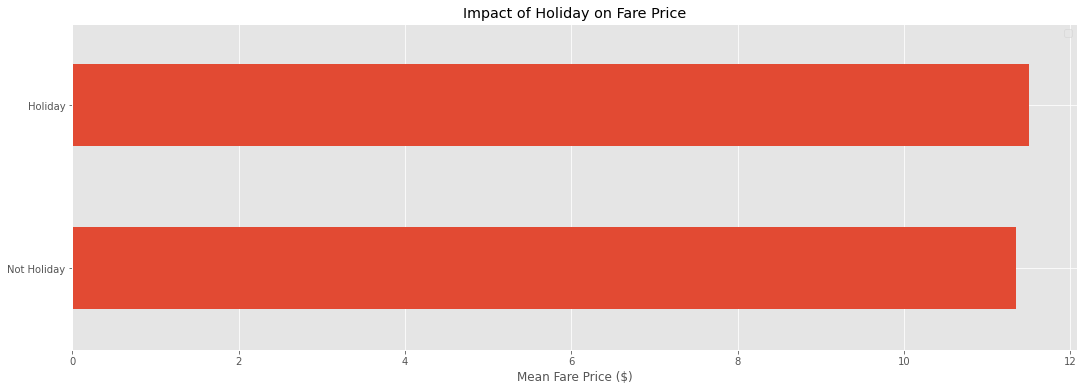

In [6]:
_ = df[['is_holiday', 'fare_amount']].groupby(['is_holiday']).mean().plot.barh(figsize=(18, 6))
plt.title('Impact of Holiday on Fare Price')
plt.legend([])
plt.xlabel('Mean Fare Price ($)')
plt.ylabel('')
plt.xticks(rotation=0)
plt.yticks(range(2), ['Not Holiday', 'Holiday'])
plt.show()

As we can see, in this specific dataset, holidays aren't making THAT difference on mean fare price. We can conclude that it doesn't provide too much predictive information for a regressor. Let's see the distribution of observations for holidays and not holidays to understand more the data.

In [7]:
df.is_holiday.value_counts()

0    191768
1      4445
Name: is_holiday, dtype: int64

Well, the lower amount of observations for holidays (which is natural in the real world) makes me think that the *is_holiday* variable may be excluded in a low variance filtering process, but we'll stick with this variable in our dataset anyway.

### Feature Importance Analysis
Now I'll be using XGBRegressor for calculating and ranking features importance. I'll not select the features right now, only in the machine learning modeling phase.

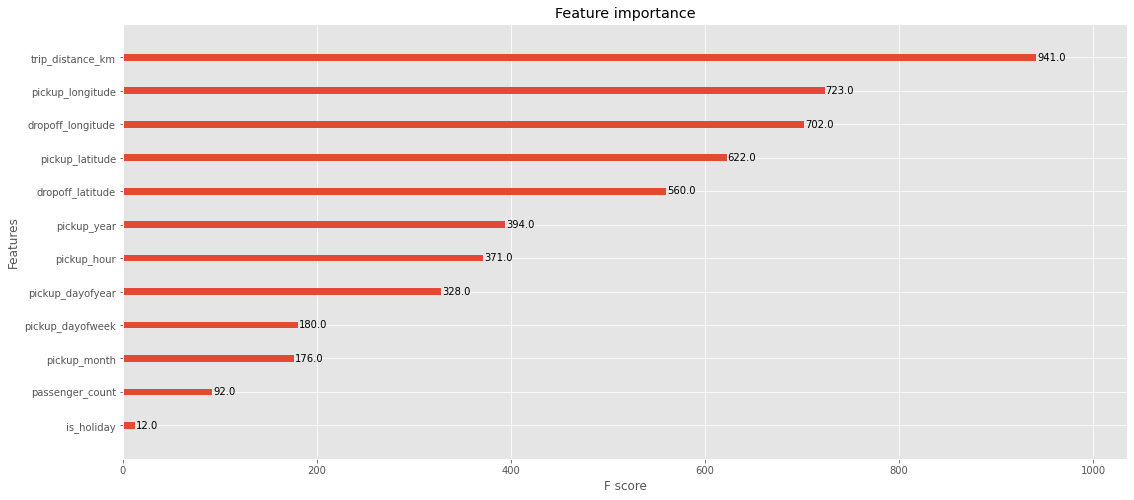

In [8]:
calc_feature_importance(df, target='fare_amount')

It seems like it was a good idea to extract not only the year and month from the data, but also the yearly and weekly days and hourly information the way I did, because these variables exposes a lot of predictive information to the model.

Another thing that worth mentioning is that, as we expected, the *is_holiday* variable has little-to-no predictive power, as the feature importance calculation process just pointed out. In the dataset's Kaggle page there is no information regarding holiday effect on the data, but I decided to check this on each row anyway.